<a href="https://colab.research.google.com/github/minsung6333/AIFFEL_Quest/blob/main/exp_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **뉴스 요약봇 만들기**
- 뉴스기사를 추출적요약과 추상적요약을 진행해보고 이를 실제 요약문과 비교하여 확인해보고
---

### 루브릭

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
  - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
  - 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
  - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

### 학습과정
1. 데이터 수집하기
2. 데이터 전처리하기(추상적 요약)
3. 어텐션 메커니즘 사용하기 (추상적 요약)
4. 실제 결과와 요약문 비교하기 (추상적 요약)
5. Summa을 이용해서 추출적 요약해보기


### 회고

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 998.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=f0d8bfa26ab3c2705c518fdc3e3e4c9fb163396f7ee9ea200e799478f11bc875
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [3]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.8.1
2.13.0
1.5.3
1.2.0


# 데이터 수집


In [5]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.sample(10)

,headlines,text
4487,"India never considered Pakistan, China as its ...",Senior RSS leader Suresh 'Bhaiyyaji' Joshi on ...
59384,What makes quantum encrypted networks 'unhacka...,"Scientists are developing global-scale ""quantu..."
96346,Will try to hit ton and celebrate with two swo...,"Indian all-rounder Ravindra Jadeja, who scored..."
36186,Shoot location of Salman's Race 3 to shift to ...,"As per reports, the shoot location of the Salm..."
55091,Terror caused by foreign interference in Pak: ...,"In an apparent attack on the US, Pakistan Pres..."
61205,IFFI head resigns over I&B Ministry dropping t...,Filmmaker Sujoy Ghosh has resigned from the po...
97410,What have been the past attempts to resolve Ay...,The attempts to settle the Ayodhya dispute out...
42946,Sunil wanted his name in title of Kapil's new ...,"As per reports, Sunil Grover rejected Kapil Sh..."
59597,3 dead as 13 coaches of Goa-Patna train derail...,As many as 13 coaches of Vasco Da Gama-Patna E...
8437,Every relationship has its ups and downs: Zoma...,"A Zomato user, who was angry over the delay in..."


In [9]:
len(data)

98401

# 데이터 전처리
## (1) 데이터 정리
- 중복샘플 제거


In [10]:
# 중복데이터 유무 파악
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [11]:
# text열 중복제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [12]:
#데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


[정규화사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [13]:
# 텍스트 정규화
contractions = {
  "ain't": "am not / are not / is not / has not / have not",
  "aren't": "are not / am not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he had / he would",
  "he'd've": "he would have",
  "he'll": "he shall / he will",
  "he'll've": "he shall have / he will have",
  "he's": "he has / he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how has / how is / how does",
  "I'd": "I had / I would",
  "I'd've": "I would have",
  "I'll": "I shall / I will",
  "I'll've": "I shall have / I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had / it would",
  "it'd've": "it would have",
  "it'll": "it shall / it will",
  "it'll've": "it shall have / it will have",
  "it's": "it has / it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she shall / she will",
  "she'll've": "she shall have / she will have",
  "she's": "she has / she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so as / so is",
  "that'd": "that would / that had",
  "that'd've": "that would have",
  "that's": "that has / that is",
  "there'd": "there had / there would",
  "there'd've": "there would have",
  "there's": "there has / there is",
  "they'd": "they had / they would",
  "they'd've": "they would have",
  "they'll": "they shall / they will",
  "they'll've": "they shall have / they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had / we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what shall / what will",
  "what'll've": "what shall have / what will have",
  "what're": "what are",
  "what's": "what has / what is",
  "what've": "what have",
  "when's": "when has / when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where has / where is",
  "where've": "where have",
  "who'll": "who shall / who will",
  "who'll've": "who shall have / who will have",
  "who's": "who has / who is",
  "who've": "who have",
  "why's": "why has / why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you shall have / you will have",
  "you're": "you are",
  "you've": "you have"
}

In [18]:
import nltk
from nltk.corpus import stopwords

#NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [19]:
# 사전 요약된 headline의 경우 문장의 길이가 짧기 때문에 불용어는 미제거함

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headline)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [20]:
#훈련 데이터 전체에 대해 전처리
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 상위 5개의 줄 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [21]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))  #False:불용어 제거를 수행하지 않는다는 의미

print("headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-19-b6845d510c72>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [23]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [24]:
#Null값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [25]:
#빈 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


## train test데이터로 나누기
- 샘플의 최대길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.103599023993496
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 19
헤드라인의 평균 길이 : 9.307015046766978


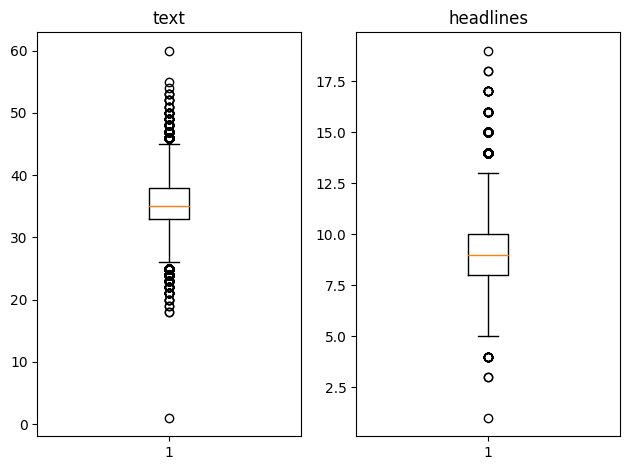

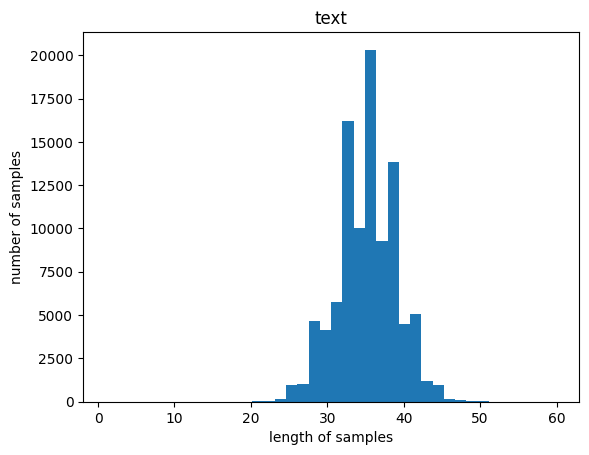

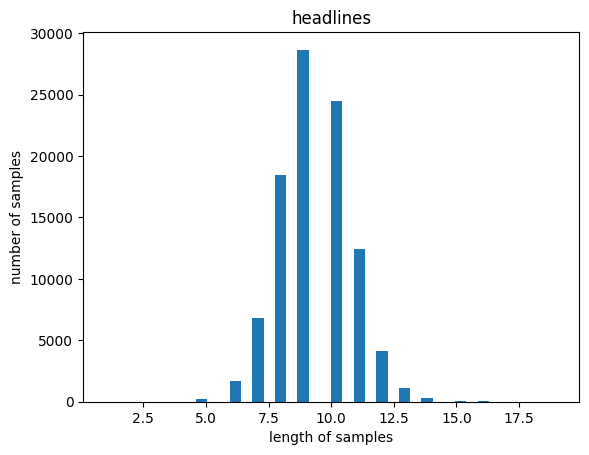

In [26]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
#Text의 최대 길이와 Headlines의 적절한 최대 길이 임의로 정하기
text_max_len = 60  #텍스트의 최대 길이
headlines_max_len = 16  #헤드라인의 최대 길이

In [29]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [30]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 0.9998881659211062


In [32]:
# 각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 하네요.
# 우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98349


요약 데이터에는 시작토큰과 종료 토큰 추가

In [33]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [34]:
#numpy로 다시 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [35]:
# 훈련 데이터와 테스트 데이터를 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[52383  7726 88783 ... 12234 27199 50425]


In [36]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [37]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19669


In [38]:
# 이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분할게요. :표시의 위치에 주의해 주세요.
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78680
훈련 레이블의 개수 : 78680
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


## 정수인코딩
- 단어집합 만들기 및 정수 인코딩

In [39]:
# 단어 집합(vocabulary) 만들기 및 정수 인코딩
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [40]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69878
등장 빈도가 6번 이하인 희귀 단어의 수: 47782
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22096
단어 집합에서 희귀 단어의 비율: 68.37917513380462
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5184409530743004


In [41]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [42]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2, 1124, 392, 5, 2872, 2946, 1024, 255, 3210, 1906, 1024, 2053, 1842, 2, 4100, 1, 9492, 1474, 392, 1082, 4, 2, 1024, 1906, 5087, 17, 1124, 2, 5188, 12, 21, 2848, 2998, 1024, 5018, 2658], [2999, 112, 40, 26, 100, 127, 706, 1875, 112, 131, 22, 1359, 2590, 1603, 1135, 143, 302, 73, 112, 2171, 100, 823, 1110, 640, 411, 718, 7, 435, 40, 273, 2258, 492, 2728, 159, 134], [668, 62, 327, 2849, 802, 4883, 280, 2621, 332, 28, 1196, 29, 1018, 7802, 668, 1, 1498, 7802, 701, 281, 2621, 632, 1181, 472, 329, 378, 260, 3, 10, 1044, 2699, 9493, 242, 8274, 11275, 520, 1147, 1425, 9687]]


In [43]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [46]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30198
등장 빈도가 5번 이하인 희귀 단어의 수: 19783
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10415
단어 집합에서 희귀 단어의 비율: 65.51096099079409
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.663614313423984


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지하고 있네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.66%밖에 되지 않아요. 아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 10,000을 단어 집합의 크기로 제한할게요.

In [47]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 9, 2011, 866, 24, 10, 2600, 287, 1142, 587], [1, 49, 2552, 282, 3, 519, 3, 5035, 195, 12, 945], [1, 161, 593, 2080, 4, 5431, 337, 8217, 5659], [1, 2856, 23, 3199, 535, 16, 2601, 260, 1133], [1, 838, 4838, 3700, 1928, 3, 1592, 316, 846]]
target
decoder  [[9, 2011, 866, 24, 10, 2600, 287, 1142, 587, 2], [49, 2552, 282, 3, 519, 3, 5035, 195, 12, 945, 2], [161, 593, 2080, 4, 5431, 337, 8217, 5659, 2], [2856, 23, 3199, 535, 16, 2601, 260, 1133, 2], [838, 4838, 3700, 1928, 3, 1592, 316, 846, 2]]


In [48]:
# 빈 샘플 제거 및 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78680
훈련 레이블의 개수 : 78680
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


In [50]:
#패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 모델설계

In [51]:
#함수형 API
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [52]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [53]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 128)              2816000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

## 어텐션 매커니즘

In [54]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 128)              2816000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [55]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 378s 1s/step - loss: 4.5164 - val_loss: 4.2186
Epoch 2/50
308/308 [==============================] - 293s 951ms/step - loss: 4.2344 - val_loss: 4.1757
Epoch 3/50
308/308 [==============================] - 294s 956ms/step - loss: 4.1650 - val_loss: 4.0982
Epoch 4/50
308/308 [==============================] - 284s 922ms/step - loss: 4.0917 - val_loss: 4.0283
Epoch 5/50
308/308 [==============================] - 284s 923ms/step - loss: 4.0015 - val_loss: 3.9420
Epoch 6/50
308/308 [==============================] - 284s 922ms/step - loss: 3.9105 - val_loss: 3.8413
Epoch 7/50
308/308 [==============================] - 282s 916ms/step - loss: 3.8177 - val_loss: 3.7583
Epoch 8/50
308/308 [==============================] - 283s 918ms/step - loss: 3.7374 - val_loss: 3.7037
Epoch 9/50
308/308 [==============================] - 282s 915ms/step - loss: 3.6662 - val_loss: 3.6421
Epoch 10/50
308/308 [==============================] - 281s 911ms/s

Es를 빼고 싶었지만 시간이 너무 오래걸리는 문제가 있어 포함하여 학습시작
기존 학습과는 달리 사전에서 제외하는 단어의 양을 줄여서 데이터셋을 구축하여 기존 데이터 대비 약 4배정도의 학습사전이 구축되어 시간역시 오래걸림.
es이 될 줄 알았으나 실패..

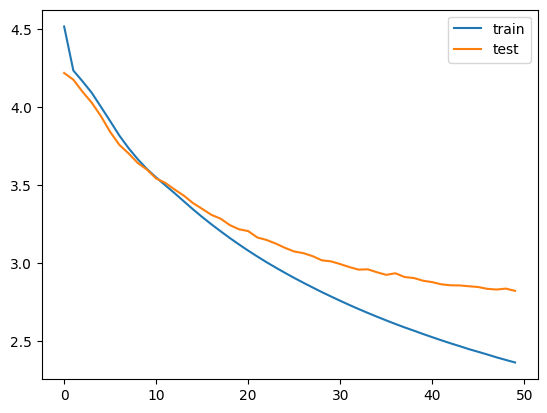

In [56]:
#시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
#텍스트 데이터 복원을 위해 3개 사전 정의
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [59]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [64]:
#어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [60]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# 실제 결과와 요약문 비교하기(추상적 요약)

In [65]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : emotional tribute father five time tamil nadu cm karunanidhi son mk stalin wrote always called call karunanidhi wanted man worked without rest finally written grave stalin added tamil poem shared social media 
실제 요약 : my leader can call you once karunanidhi son stalin 
1/1 [==============================] - 0s 55ms/step
예측 요약 :  my father of my father of my dad on dad demise


원문 : javed former seven time national champion given triple talaq husband phone giving birth girl got married alleged laws also harassed dowry despite father depositing lakh account written pm narendra modi cm adityanath help 
실제 요약 : ex champ given triple talaq for giving birth to girl 
1/1 [==============================] - 0s 22ms/step
예측 요약 :  ex gay priest who raped me for sex with husband


원문 : pregnant goat allegedly gangraped eight men haryana wednesday died day later complaint filed goat owner police said medical investigation dead goat conducted people accused currently absconding added 
실제 요약 : p

# summa을 이용해서 추출적 요약해보기

In [4]:
#추출적요약

import requests
from summa.summarizer import summarize

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.sample(10)

,headlines,text
4933,Salman Khan to launch Mahesh Manjrekar's daugh...,Salman Khan will be launching Mahesh Manjrekar...
13950,AAP leader burnt alive by alleged boyfriend he...,AAP leader Naveen Das' body was recovered from...
47243,400 tribals employed as Maoist-affected Bastar...,"Chhattisgarh's Bastar, which is among the wors..."
55629,Big B's Ã¢ÂÂ¹1.6cr investment in blockchain f...,The value of an investment by Amitabh and Abhi...
87039,Thailand named world's best destination for re...,Thailand was named the world's best destinatio...
34453,Man arrested for breaking into Taylor Swift's ...,A man has been arrested for breaking into sing...
63490,Gandhi's kin moves SC opposing reopening of hi...,Mahatma Gandhi's great-grandson Tushar Gandhi ...
68606,Angela Merkel wins fourth term as German Chanc...,Angela Merkel on Sunday won her fourth term as...
90893,USA cricket governing body faces expulsion fro...,The United States of America Cricket Associati...
18373,Pak will not fight any other country's war: PM...,Pakistan will not fight any other country's wa...


In [7]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.40))
    # print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

# 회고

**작업에 관하여**

본 프로젝트에서 학습데이터의 최소한의 손실로 학습을 진행해보고자 했습니다.
이과정에서 abstractive summarization를 위한 학습시간이 오래걸리는(약 4시간) 문제점과, 작업환경인 colab으로 인하여 특정 시간이 지났을 시 세션이 만료되는 문제점이 생겼습니다. 2가지 문제점으로 인하여 추가적인 학습을 진행하기 어려웠으며, 학습간 모델 저장에 대한 필요성을 느꼈습니다.

[모델저장 가이드](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko)
```
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images,
          train_labels,
          epochs=50,
          batch_size=batch_size,
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)
```

**학습결과에 관하여**

attention을 통하여 abstractive summarization하는 모델을 구축하는 과정에서 설정했던 epoch가 적절하지 않았음. 설정했던 epoch는 loss값을 최소까지 이끌어내지 않았던 것 같습니다.
abstractive summarization의 경우 문법적으로 의미상으로 관련없는 글을 결과로 내는 경우가 많은 것으로 확인됩니다.
> 원문 headline : ex champ given triple talaq for giving birth to girl

> 추출요약 결과 : ex gay priest who raped me for sex with husband


**평가에 관하여**

summarization에 대한 성능평가의 경우 정답 문장의 n-gram이 생성 문장에 얼마나 포함되는지의 비율인 ROUGE score를 이용하여 성능을 측정하는 것으로 확인했으며, abstractive의 경우 해당 지표를 통하여 측정할 경우 extractive 보다 오히려 성능이 떨어지는 구조상의 문제점이 있는 것으로 확인했습니다.
